In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cmasher as cmr
cmap=cmr.sunburst_r
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [3]:
# function needed
def get_bounds_and_grids(data, pawprint):
    
    phi1_lim = (jnp.min(data['phi1']), jnp.max(data['phi1']))
    phi2_lim = (jnp.min(data['phi2']), jnp.max(data['phi2']))
    pm1_lim = (jnp.min(pawprint.pmprint.vertices[:,0]), jnp.max(pawprint.pmprint.vertices[:,0]))
    pm2_lim = (jnp.min(pawprint.pmprint.vertices[:,1]), jnp.max(pawprint.pmprint.vertices[:,1]))
    rv_lim = (jnp.min(data['rv']), jnp.max(data['rv']))

    coord_bounds = {"phi1": phi1_lim, "phi2": phi2_lim, "pm1": pm1_lim, "pm2": pm2_lim, "rv": rv_lim}
    
    plot_grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "phi2": jnp.linspace(*phi2_lim, 128),
    "pm1": jnp.linspace(*pm1_lim, 128),
    "pm2": jnp.linspace(*pm2_lim, 128),
    "rv": jnp.linspace(*rv_lim, 128)
}
    return coord_bounds, plot_grids

In [5]:
with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

In [6]:
only_rv_run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
only_rv_bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
only_rv_stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

# Fill in rv data for rows without it (rv=0, rv_err=1e4)
run_data_['rv'][run_data_['rv'].mask] = 0
run_data_['rv_err'][run_data_['rv_err'].mask] = 1e4

bkg_data_['rv'][bkg_data_['rv'].mask] = 0
bkg_data_['rv_err'][bkg_data_['rv_err'].mask] = 1e4

stream_data_['rv'][stream_data_['rv'].mask] = 0
stream_data_['rv_err'][stream_data_['rv_err'].mask] = 1e4

In [7]:
print(len(run_data_))
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
run_data_err = {'pm1': jnp.array(run_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(run_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(run_data_['rv_err'], dtype="f8")}

bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

83735


In [8]:
coord_bounds, plot_grids = get_bounds_and_grids(run_data, pawprint)

In [9]:
bkg_knot_spacings    = jnp.array([40,40,40,40])
stream_knot_spacings = jnp.array([5,10,10,10,10])
offtrack_dx          = jnp.array([3,1])

#### Load model and results

In [10]:
specifications = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings, offtrack_dx])

svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_{}_stream{}_{}_{}_{}_{}_off{}_{}_auto_normal.pkl'.format(*specifications)

with open(filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
svi_results = full_dict['svi_results']
guide = full_dict['guide']

mm = guide.model

Instead of taking the mean, I can just take the autoloc and convert that to the contrained space.

In [11]:
auto_loc_params_ = {}
for key, val in svi_results.params.items():
    if "auto_scale" in key:
        auto_loc_params_[key] = val/1e10
    else:
        auto_loc_params_[key] = val
# auto_loc_params_ = {key: val/1e10 for key, val in svi_results.params.items() if "auto_scale" in key}
pred_dist_auto_loc = Predictive(guide, params=auto_loc_params_, num_samples=1)
pars_auto_loc_ = pred_dist_auto_loc(jax.random.PRNGKey(12345), data=run_data)
pars_auto_loc = {k: jnp.median(v, axis=0) for k, v in pars_auto_loc_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
best_params = mm.expand_numpyro_params(pars_auto_loc)

In [12]:
pred_dist = Predictive(guide, params=svi_results.params, num_samples=1_000)
pars_ = pred_dist(jax.random.PRNGKey(12345), data=run_data)
pars = mm.expand_numpyro_params(pars_)

#### Using the best params

In [13]:
# check that this sums to 1
best_params['stream']['phi1']['mixing_distribution'].sum()

Array(1., dtype=float64)

In [14]:
offtrack_phi1_dx, offtrack_phi2_dx = offtrack_dx

phi1_lim = coord_bounds['phi1']
phi2_lim = coord_bounds['phi2']

offtrack_phi12_locs = jnp.stack(
jnp.meshgrid(
    jnp.arange(phi1_lim[0]+offtrack_phi1_dx, 
               phi1_lim[1]-offtrack_phi1_dx/2 + 1e-3, #factor of two added by hand to make sure the high phi1 edge is properly included
               offtrack_phi1_dx),
    jnp.arange(phi2_lim[0]+offtrack_phi2_dx, 
               phi2_lim[1]-offtrack_phi2_dx/2 + 1e-3, 
               offtrack_phi2_dx),
),
axis=-1,
).reshape(-1, 2)

(-100.0, 20.0)

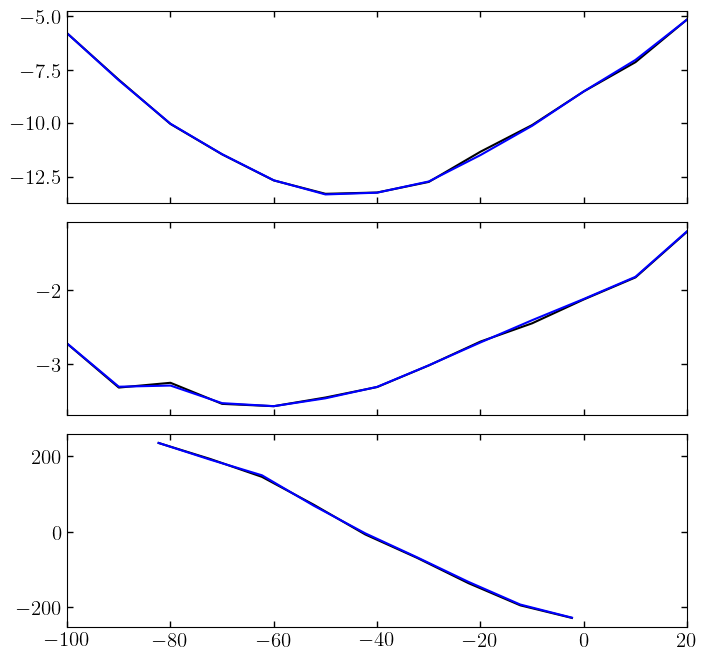

In [15]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(8,8), sharex=True)
ax1.plot(mm['offtrack'].coord_parameters['pm1']['knots'], best_params['offtrack']['pm1']['loc_vals'])
ax1.plot(mm['stream'].coord_parameters['pm1']['knots'], best_params['stream']['pm1']['loc_vals'])

ax2.plot(mm['offtrack'].coord_parameters['pm2']['knots'], best_params['offtrack']['pm2']['loc_vals'])
ax2.plot(mm['stream'].coord_parameters['pm2']['knots'], best_params['stream']['pm2']['loc_vals'])

ax3.plot(mm['offtrack'].coord_parameters['rv']['knots'], best_params['offtrack']['rv']['loc_vals'])
ax3.plot(mm['stream'].coord_parameters['rv']['knots'], best_params['stream']['rv']['loc_vals'])
ax3.set_xlim(-100,20)

In [16]:
print(best_params['mixture-probs'])

[0.98461379 0.01403251 0.0013537 ]


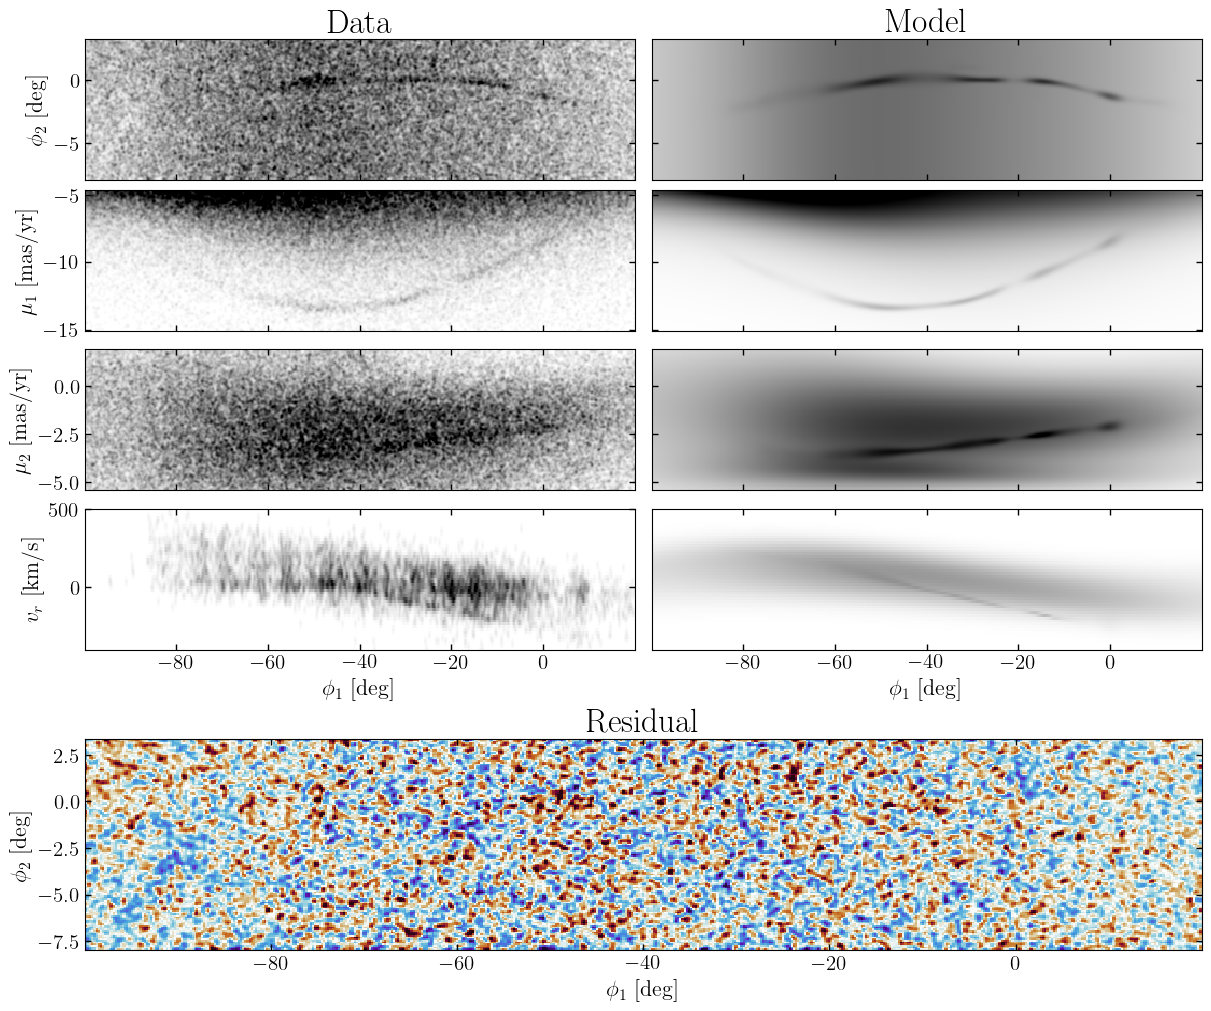

In [17]:
cmap='gray_r'
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_run_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=best_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_['rv'][run_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=best_params, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=best_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm.plot_residual_projections(
    grids=plot_grids, pars=best_params,
    data=run_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

plt.show()

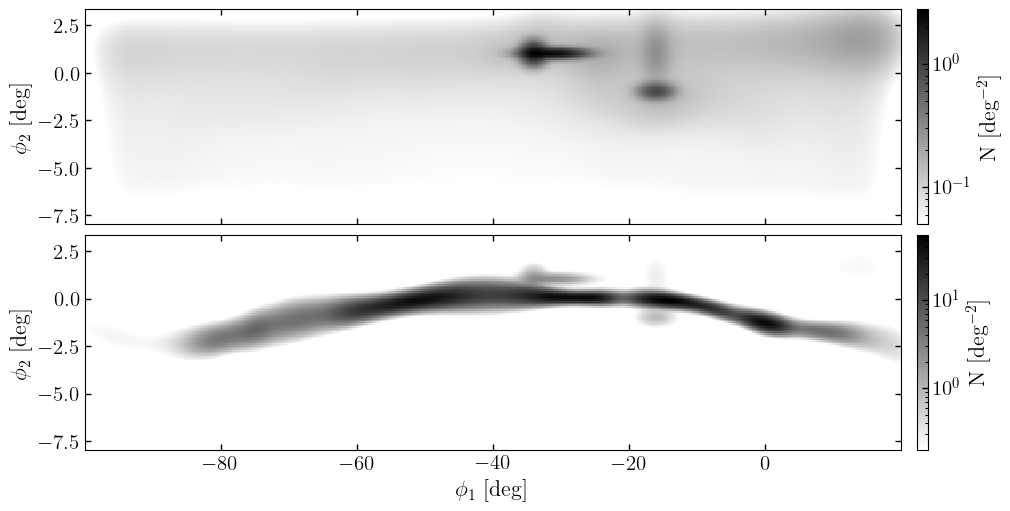

In [18]:
deltaphi1=plot_grids['phi1'][1]-plot_grids['phi1'][0]
deltaphi2=plot_grids['phi2'][1]-plot_grids['phi2'][0]

str_off_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[mm['stream'], mm['offtrack']],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
    )

str_off_mm_params = {
    "stream": best_params["stream"],
    "offtrack": best_params["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = best_params["mixture-probs"][1:] / jnp.sum(best_params["mixture-probs"][1:])
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)


fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,5), sharex=True, constrained_layout=True)
_, _, pcms1 = mm['offtrack'].plot_model_projections(ndata=len(run_data_)* best_params["mixture-probs"][2], 
                                                    grids=plot_grids, pars=best_params['offtrack'], grid_coord_names=[('phi1', 'phi2')], 
                                                    axes=ax1, pcolormesh_kwargs=dict(rasterized=True, cmap=cmap, norm=mpl.colors.LogNorm(vmin=0.001 , vmax=0.1)))
ax1.scatter(mm['offtrack'].coord_parameters[('phi1','phi2')]['locs'][0], 
            mm['offtrack'].coord_parameters[('phi1','phi2')]['locs'][1], color="tab:blue", s=3)
im1 = ax1.pcolormesh(plot_grids['phi1'], plot_grids['phi2'], pcms1[0].get_array().data/(deltaphi1*deltaphi2),
                     rasterized=True, cmap=cmap, norm=mpl.colors.LogNorm(vmin=0.05))#, norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.02)

_, _, pcms2 = str_off_mm.plot_model_projections(ndata=len(run_data_) * jnp.sum(best_params["mixture-probs"][1:]),
                                                pars=str_off_mm_packed_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
                                                pcolormesh_kwargs=dict(rasterized=True, norm=mpl.colors.LogNorm(vmin=0.005), cmap=cmap))

# _, _, pcms2 = mm['stream'].plot_model_projections(ndata=len(run_data_),
#                                                 pars=MAP_p_expanded['stream'], grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
#                                                 pcolormesh_kwargs=dict(rasterized=True, cmap=cmap))
im2 = ax2.pcolormesh(plot_grids['phi1'], plot_grids['phi2'], pcms2[0].get_array().data/(deltaphi1*deltaphi2),
                     rasterized=True, cmap=cmap, norm=mpl.colors.LogNorm(vmin=0.2))
cbar2 = fig.colorbar(im2, ax=ax2, pad=0.02)




ax1.set_xlabel("")
cbar1.set_label(label=r'N [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'N [deg$^{-2}$]', fontsize=16)
plt.show()

### Make Linear Density Plot

In [19]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = best_params['stream']
offtrack_params = best_params['offtrack']

grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [20]:
deltaphi1=plot_grids['phi1'][1]-plot_grids['phi1'][0]
deltaphi2 = plot_grids['phi2'][1]-plot_grids['phi2'][0]

In [21]:
stream_lin_dens0 = (jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) * deltaphi2)
off_lin_dens0 = (jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) * deltaphi2)

In [22]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
phi1s_rv = phi1s[(phi1s>-82)&(phi1s<3)]
ndata = len(run_data_)

deltaphi1=plot_grids['phi1'][1]-plot_grids['phi1'][0]
deltaphi2 = plot_grids['phi2'][1]-plot_grids['phi2'][0]
stream_lin_dens = ndata*best_params['mixture-probs'][1] * jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) * deltaphi2
off_lin_dens = ndata*best_params['mixture-probs'][2] * jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) * deltaphi2

# uncomment if you want the other panels as well

# phi2_track = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['loc_vals'])
# phi2_width = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['scale_vals'])

# stream_pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['stream:pm1:loc_vals'], 50, axis=0))
# stream_pm1_track_low = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['stream:pm1:loc_vals'], 16, axis=0))
# stream_pm1_track_high = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['stream:pm1:loc_vals'], 84, axis=0))
# stream_pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['scale_vals'])
# stream_pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])
# stream_pm2_track_low = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['stream:pm2:loc_vals'], 16, axis=0))
# stream_pm2_track_high = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['stream:pm2:loc_vals'], 84, axis=0))
# stream_pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['scale_vals'])
# stream_rv_track = IUS(stream_opt.coord_parameters['rv']['knots'], stream_params['rv']['loc_vals'])
# stream_rv_track_low = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['stream:rv:loc_vals'], 16, axis=0))
# stream_rv_track_high = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['stream:rv:loc_vals'], 84, axis=0))
# stream_rv_width = IUS(stream_opt.coord_parameters['rv']['knots'], stream_params['rv']['scale_vals'])

# offtrack_pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], offtrack_params['pm1']['loc_vals'])
# offtrack_pm1_track_low = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['offtrack:pm1:loc_vals'], 16, axis=0))
# offtrack_pm1_track_high = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['offtrack:pm1:loc_vals'], 84, axis=0))
# offtrack_pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], offtrack_params['pm1']['scale_vals'])
# offtrack_pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], offtrack_params['pm2']['loc_vals'])
# offtrack_pm2_track_low = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['offtrack:pm2:loc_vals'], 16, axis=0))
# offtrack_pm2_track_high = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['offtrack:pm2:loc_vals'], 84, axis=0))
# offtrack_pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], offtrack_params['pm2']['scale_vals'])
# offtrack_rv_track = IUS(stream_opt.coord_parameters['rv']['knots'], offtrack_params['rv']['loc_vals'])
# offtrack_rv_track_low = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['offtrack:rv:loc_vals'], 16, axis=0))
# offtrack_rv_track_high = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['offtrack:rv:loc_vals'], 84, axis=0))
# offtrack_rv_width = IUS(stream_opt.coord_parameters['rv']['knots'], offtrack_params['rv']['scale_vals'])

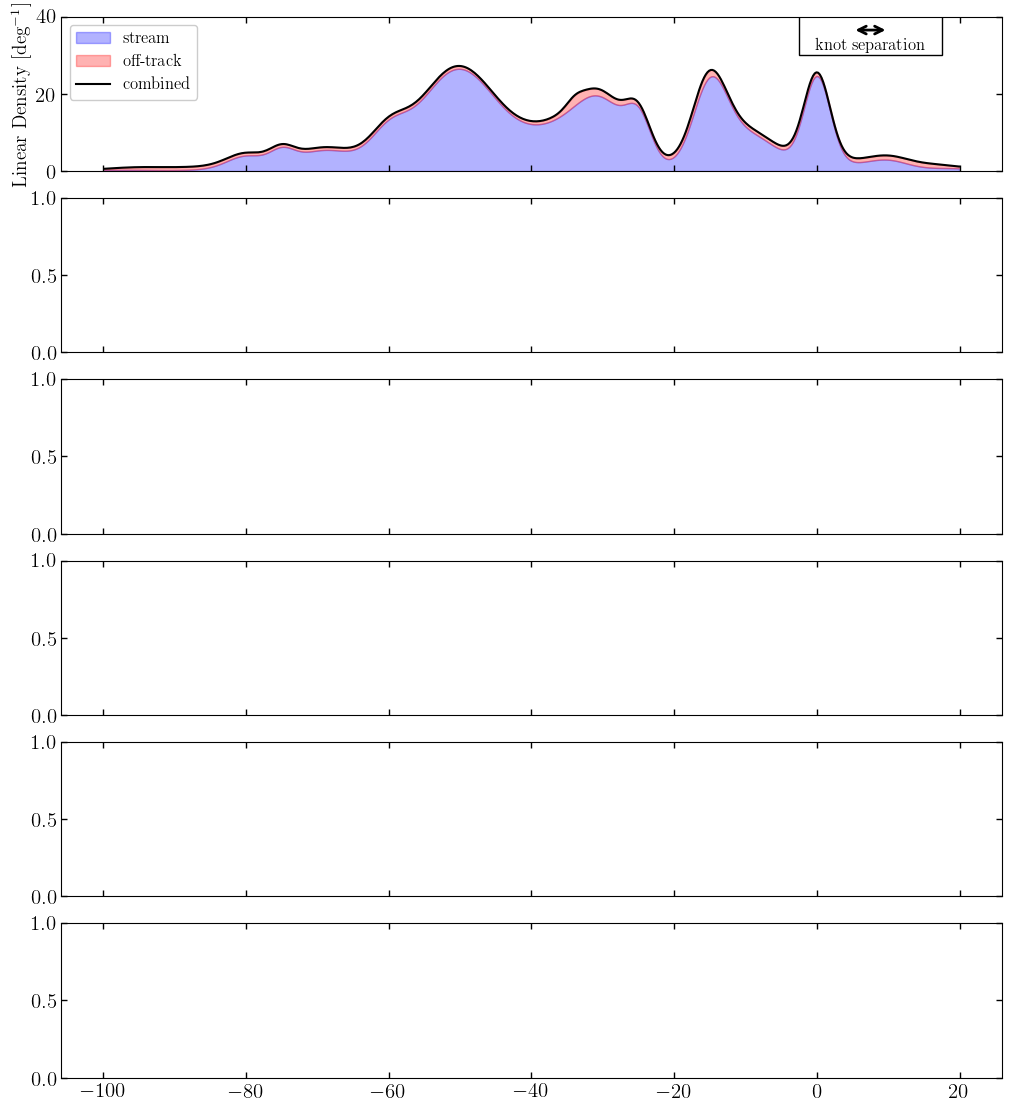

In [23]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, 0, stream_lin_dens, color='b', alpha=0.3, label=r'stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='r', alpha=0.3, label=r'off-track')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'combined')
ax1.annotate("", xy=(10,36.5), xytext=(10-stream_knot_spacings[0],36.5), arrowprops=dict(arrowstyle="<->", linewidth=2, color="black"))
magic_box1 = mpl.patches.Rectangle((7.5 - 20 / 2, 35 - 10 / 2), 20, 25, facecolor="white", edgecolor="black", linewidth=1, zorder=2)
ax1.add_patch(magic_box1)
ax1.text(10-0.5*stream_knot_spacings[0], 32.5, "knot separation", fontsize=12, ha="center", va="center")
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,40)
ax1.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, framealpha=1)

# ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'$\phi_2$ track')
# ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
#                  color='b', alpha=0.3, label=r'$\phi_2$ track w/ width')
# ax2.annotate("", xy=(12.5,2), xytext=(12.5-stream_knot_spacings[1],2), arrowprops=dict(arrowstyle="<->", linewidth=2, color="black"))
# ax2.text(12.5-0.5*stream_knot_spacings[1], 1, "knot separation", fontsize=12, ha="center", va="center")
# ax2.set_ylim(-7, 3)
# ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
# ax2.legend(fontsize=12, loc='upper left')

# # ax3.plot(phi1s, stream_pm1_track(phi1s), c='k', label=r'stream $\mu_1$ track')
# ax3.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
# ax3.text(1, -12.8, r'Median $\mu_1$ Error', fontsize=12)
# ax3.fill_between(phi1s, stream_pm1_track_low(phi1s), stream_pm1_track_high(phi1s), 
#                  color='b', alpha=0.3, label=r'stream $\mu_1$ track 16th-84th percentiles')
# ax3.fill_between(phi1s, offtrack_pm1_track_low(phi1s), offtrack_pm1_track_high(phi1s), 
#                  color='r', alpha=0.3, label=r'off-track $\mu_1$ track 16th-84th percentiles')
# ax3.set_ylabel(r'$\mu_1$ [mas/yr]', fontsize=14)
# # ax3.set_ylim(-18,-4)
# ax3.legend(fontsize=12, loc='upper left', ncol=3)

# # ax4.plot(phi1bs, stream_pm2_track(phi1s), c='k', label=r'stream $\mu_2$ track')
# ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
# ax4.text(1, -3.8, r'Median $\mu_2$ Error', fontsize=12)
# ax4.fill_between(phi1s, stream_pm2_track_low(phi1s), stream_pm2_track_high(phi1s), 
#                  color='b', alpha=0.3, label=r'stream $\mu_2$ track 16th-84th percentiles')
# ax4.fill_between(phi1s, offtrack_pm2_track_low(phi1s), offtrack_pm2_track_high(phi1s), 
#                  color='r', alpha=0.3, label=r'off-track $\mu_2$ track 16th-84th percentiles')
# ax4.set_ylabel(r'$\mu_2$ [mas/yr]', fontsize=14)
# ax4.legend(fontsize=12, loc='upper left', ncol=3)

# # ax5.plot(phi1s, stream_rv_track(phi1s), c='k', label=r'stream $v_r$ track')
# # ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
# # ax4.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
# ax5.fill_between(phi1s_rv, stream_rv_track_low(phi1s_rv), stream_rv_track_high(phi1s_rv),
#                  color='b', alpha=0.3, label=r'stream $v_r$ track 16th-84th percentiles')
# ax5.fill_between(phi1s_rv, offtrack_rv_track_low(phi1s_rv), offtrack_rv_track_high(phi1s_rv), 
#                  color='r', alpha=0.3, label=r'off-track $v_r$ track 16th-84th percentiles')
# ax5.set_ylabel(r'$v_r$ [km/s]', fontsize=14)
# ax5.set_ylim(-300,300)
# ax5.legend(fontsize=12, loc='lower left', ncol=3)

# ax6.plot(phi1s, phi2_width(phi1s), c='k', label=r'stream width full model')
# # ax6.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'stream width no off-track')
# ax6.set_ylim(0, 1)
# ax6.set_ylabel(r'Width [deg]', fontsize=14)
# ax6.legend(fontsize=12, loc='upper left', ncol=2)

# ax6.set_xlim(-100, 20)
# ax6.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

plt.show()